# Recogzing sounds

# Feature extraction

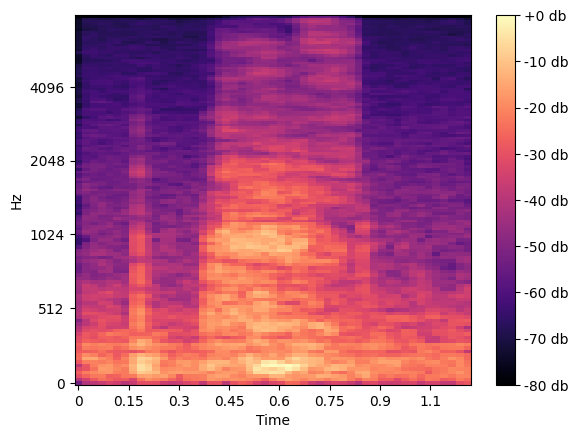

In [1]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

y, sr = librosa.load("data/scratch/Scratch-01.wav")

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

fig, ax = plt.subplots()
S_db = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_db, x_axis="time", y_axis="mel", sr=sr, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f db")
plt.show()

In [2]:
%timeit librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128), ref=np.max)

3.42 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
import glob

features = np.zeros((30, 100, 128))  # 30 files, num frames, 64 mel bands

min_frames = 1000


# Iterate through the data

def append_features(files, features, start, min_frames):
    for i, file in enumerate(files, start=start):
        y, sr = librosa.load(file)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

        S_db = librosa.power_to_db(S, ref=np.max)
        r, c = S_db.shape
        if c < min_frames:
            min_frames = c
        features[i, :c, :r] = S_db.T
    return features, min_frames


files = glob.glob("data/scratch/*.wav")
features, min_frames = append_features(files, features, 0, min_frames)

files = glob.glob("data/knock/*.wav")
features, min_frames = append_features(files, features, 10, min_frames)

files = glob.glob("data/none/*.wav")
features, min_frames = append_features(files, features, 20, min_frames)


In [4]:
print(f"Minimum frames: {min_frames}")

Minimum frames: 44


In [6]:
features = features[:, :min_frames, :]

labels = np.zeros(30)  # 0 (first 10) is scratch
labels[10:20] = 1  # knock
labels[20:] = 2  # none
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Features shape: (30, 44, 128)
Labels shape: (30,)


# Training a model

In [7]:
# Train a logistic regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = features.reshape(30, -1)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 1.0


In [8]:
# Export the model
import joblib

joblib.dump(model, "model.pkl")


['model.pkl']

In [9]:
# Load the model and perform a prediction
model = joblib.load("model.pkl")